In [20]:
%load_ext autoreload
%autoreload 2
import emcee
import numpy as np
import sys
sys.path.append('/data1/yujiehe/anisotropy-flamingo')
import tools.constants as const
import tools.clusterfit as cf
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306, Ob0=0.0486)

C = 299792.458                  # the speed of light in km/s


def log_likelihood(theta, X, Y, z_obs, phi_lc, theta_lc, yname, xname):
    """
    X, Y, z_obs, phi_lc, theta_lc, are from the data
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
       return -np.inf 
    
    delta, vlon, vlat, logA, B, sigma, = theta

    # Set the scaling relation to know the pivot point
    scaling_relation = f'{yname}-{xname}'

    # Calculate the redshift
    angle = cf.angular_separation(phi_lc, theta_lc, vlon, vlat) * np.pi/180
   
    H0_ratio = 1+delta/2*np.cos(angle)

    # Calculate the Luminosity distance
    if yname == 'LX':
        Y_mod = Y*H0_ratio**-2
    elif yname == 'YSZ':
        Y_mod = Y*H0_ratio**-2
    elif yname == 'M':
        Y_mod = Y*H0_ratio**(-5/2) # (DA_modified)**(5/2)/(DA_default)**(5/2)
        
    # To our fit parameters
    logY_ = cf.logY_(Y_mod, z=z_obs, relation=scaling_relation)
    logX_ = cf.logX_(X, relation=scaling_relation)

    model = B * logX_ + logA
    lnL = -0.5 * np.sum((logY_ - model) ** 2 / (sigma**2) + np.log(sigma**2)) # Kostas' implementation

    return lnL + lp

# set prior
def log_prior(theta):
    # A large flat prior for now
    delta, vlon, vlat, logA, B, sigma = theta # 6 parameters

    # If in range, p(theta)=1, else p(theta)=0
    if -1<logA<1 and 0.5<B<3.5 and 0.05<sigma<1 \
        and 0<delta<1 and -180<vlon<180 and -90<vlat<90:
        return 0.0
    else:
        return -np.inf


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import pandas as pd
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision_outlier_excision.csv')
data

,lc_id,redshift,theta_on_lc,phi_on_lc,M_fof_lc,x_lc,y_lc,z_lc,snap_num,MfofSOAP,...,Y5R500WithoutRecentAGNHeating,Vx,Vy,Vz,GalaxyID,TopLeafID,3DLcore/Ltot,ObservedRedshift,Flux,2DLcore/Ltot
0,12678101,0.049663,68.444418,-146.100556,3.221621e+14,-65.892905,-44.277266,200.964592,76,3.221569e+14,...,13.394281,-138.41480,146.285160,-258.814820,264729502,264729571,0.629913,0.048863,1.930583e-11,0.655002
1,13217952,0.031250,61.242576,66.517408,2.121565e+14,26.197568,60.300376,119.801093,76,2.122057e+14,...,8.353127,136.95007,85.050050,156.950070,758729120,758729192,0.563404,0.031943,3.424318e-11,0.619050
2,11897316,0.016130,-50.768598,-21.506782,9.199489e+13,41.950287,-16.530393,-55.223603,77,9.194666e+13,...,1.736042,-143.69714,-196.297180,-29.697144,735257909,735257982,0.587601,0.016076,1.415207e-11,0.580910
3,12785470,0.019369,28.752838,151.820271,1.019505e+14,-65.416111,35.046019,40.719139,77,1.019797e+14,...,2.198071,-126.92236,256.877560,1.177612,553518674,553518749,0.448886,0.020066,1.010312e-11,0.540358
4,6057316,0.077597,-74.324178,-132.555680,2.872746e+14,-61.330249,-66.799779,-323.142433,75,2.875223e+14,...,12.424476,168.31421,95.214230,99.214230,256178182,256178252,0.538358,0.077076,7.649637e-12,0.485846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,11804705,0.085544,22.449321,158.121013,5.532838e+14,-316.531368,127.109968,140.934807,75,5.530544e+14,...,77.584358,492.35680,242.556760,50.656740,795913407,795913476,0.020071,0.084388,2.813252e-11,0.060460
702,11861703,0.028225,-55.011456,-126.277785,7.538000e+13,-41.823558,-56.982167,-100.989675,76,7.531655e+13,...,2.511428,98.96692,-309.533080,-453.733030,261040288,261040362,0.020155,0.029877,7.749973e-12,0.057530
703,4646616,0.125712,-33.564085,-169.939991,8.079670e+14,-442.983802,-78.588470,-298.507096,74,8.081410e+14,...,140.383773,-671.88740,77.012570,-361.787350,690964560,690964632,0.002155,0.128495,6.101368e-12,0.047056
704,12882763,0.052263,43.009397,-35.045370,1.727982e+14,135.647971,-95.141897,154.556921,76,1.728982e+14,...,10.978919,-296.42468,159.875300,135.375300,583385361,583385430,0.011669,0.051729,5.409843e-12,0.042653


In [80]:
# Load data and set zmax
data  = data[:300]
yname = 'M'
xname = 'T'

# Load data
z_obs    = data['ObservedRedshift'].values
X        = data[cf.COLUMNS[xname]].values
Y        = data[cf.COLUMNS[yname]].values
phi_lc   = data['phi_on_lc'].values
theta_lc = data['theta_on_lc'].values

## Use a Scipy solver for initial condition

In [81]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0, 0, 0, 1, 1, 0.1]) # initial guess
bounds = [(0, 0.09), (-180, 180), (-90, 90), (0.1, 1), (0.5, 3.5), (0.05, 1)]

soln = differential_evolution(nll, args=(X, Y, z_obs, phi_lc, theta_lc, yname, xname), 
                bounds=bounds, popsize=10, strategy='rand1bin')
print(soln.x)

[ 2.38927980e-03 -8.21695231e+00  5.78981312e+01  1.00362645e-01
  2.12770449e+00  1.00585674e-01]


/data1/yujiehe/conda-env/halo/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


### MCMC with EMCEE

In [82]:
pos0 = soln.x + 1e-2 * np.random.randn(32, 6)
nwalkers, ndim = pos0.shape

# Create a sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, 
                                args=(X, Y, z_obs, phi_lc, theta_lc, yname, xname))

# Run
sampler.run_mcmc(pos0, 10000, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]/data1/yujiehe/conda-env/halo/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 28/10000 [00:00<01:25, 116.76it/s]

100%|██████████| 10000/10000 [01:16<00:00, 130.89it/s]


State([[ 1.28131140e-02 -7.39221454e+00  1.70554690e+01  3.79827354e-02
   2.00588172e+00  7.79494403e-02]
 [ 1.07569338e-02 -7.69285148e+01 -1.31316136e+00  3.08721700e-02
   2.01256491e+00  7.48540786e-02]
 [ 1.48770774e-03  6.02523349e+01 -4.15556060e+01  3.83556943e-02
   1.98717851e+00  6.74622009e-02]
 [ 5.51741094e-03  1.24168431e+02 -6.52886017e+01  3.55460474e-02
   2.03324115e+00  7.63509701e-02]
 [ 1.48656981e-02 -1.62399855e+01  3.17577225e+01  4.41762617e-02
   1.96927449e+00  7.01086105e-02]
 [ 5.76357645e-03 -1.45211939e+02  5.20877776e+01  3.13352186e-02
   1.97588918e+00  6.83076730e-02]
 [ 8.09506928e-03 -1.75962147e+02 -7.97540457e+01  3.80912077e-02
   1.98292583e+00  6.68999152e-02]
 [ 5.69956303e-03 -1.60091773e+02 -3.78557201e+01  3.14782390e-02
   2.03238771e+00  7.41848795e-02]
 [ 1.87658753e-03 -1.68001778e+02 -2.83762443e+01  3.55270804e-02
   1.98137029e+00  6.95616987e-02]
 [ 3.37015659e-03 -1.07751085e+02 -1.69583268e+01  3.18004905e-02
   1.96177906e+00  

In [83]:
try:
    tau = sampler.get_autocorr_time()
    print(tau)
except emcee.autocorr.AutocorrError:
    print('The chain is too short to get a reliable autocorrelation time.')
    tau = 0

[117.24564526 160.23561007 126.34734719  77.07330207  91.72092031
  81.10694752]


Throw away a few times this number of steps as “burn-in”. And thin by about half the autocorrelation time.

In [84]:
tau = sampler.get_autocorr_time()

In [85]:
flat_samples = sampler.get_chain(discard=1000, thin=60, flat=True)
print(flat_samples.shape)

(4800, 6)


Text(0.5, 0.98, 'M-T')

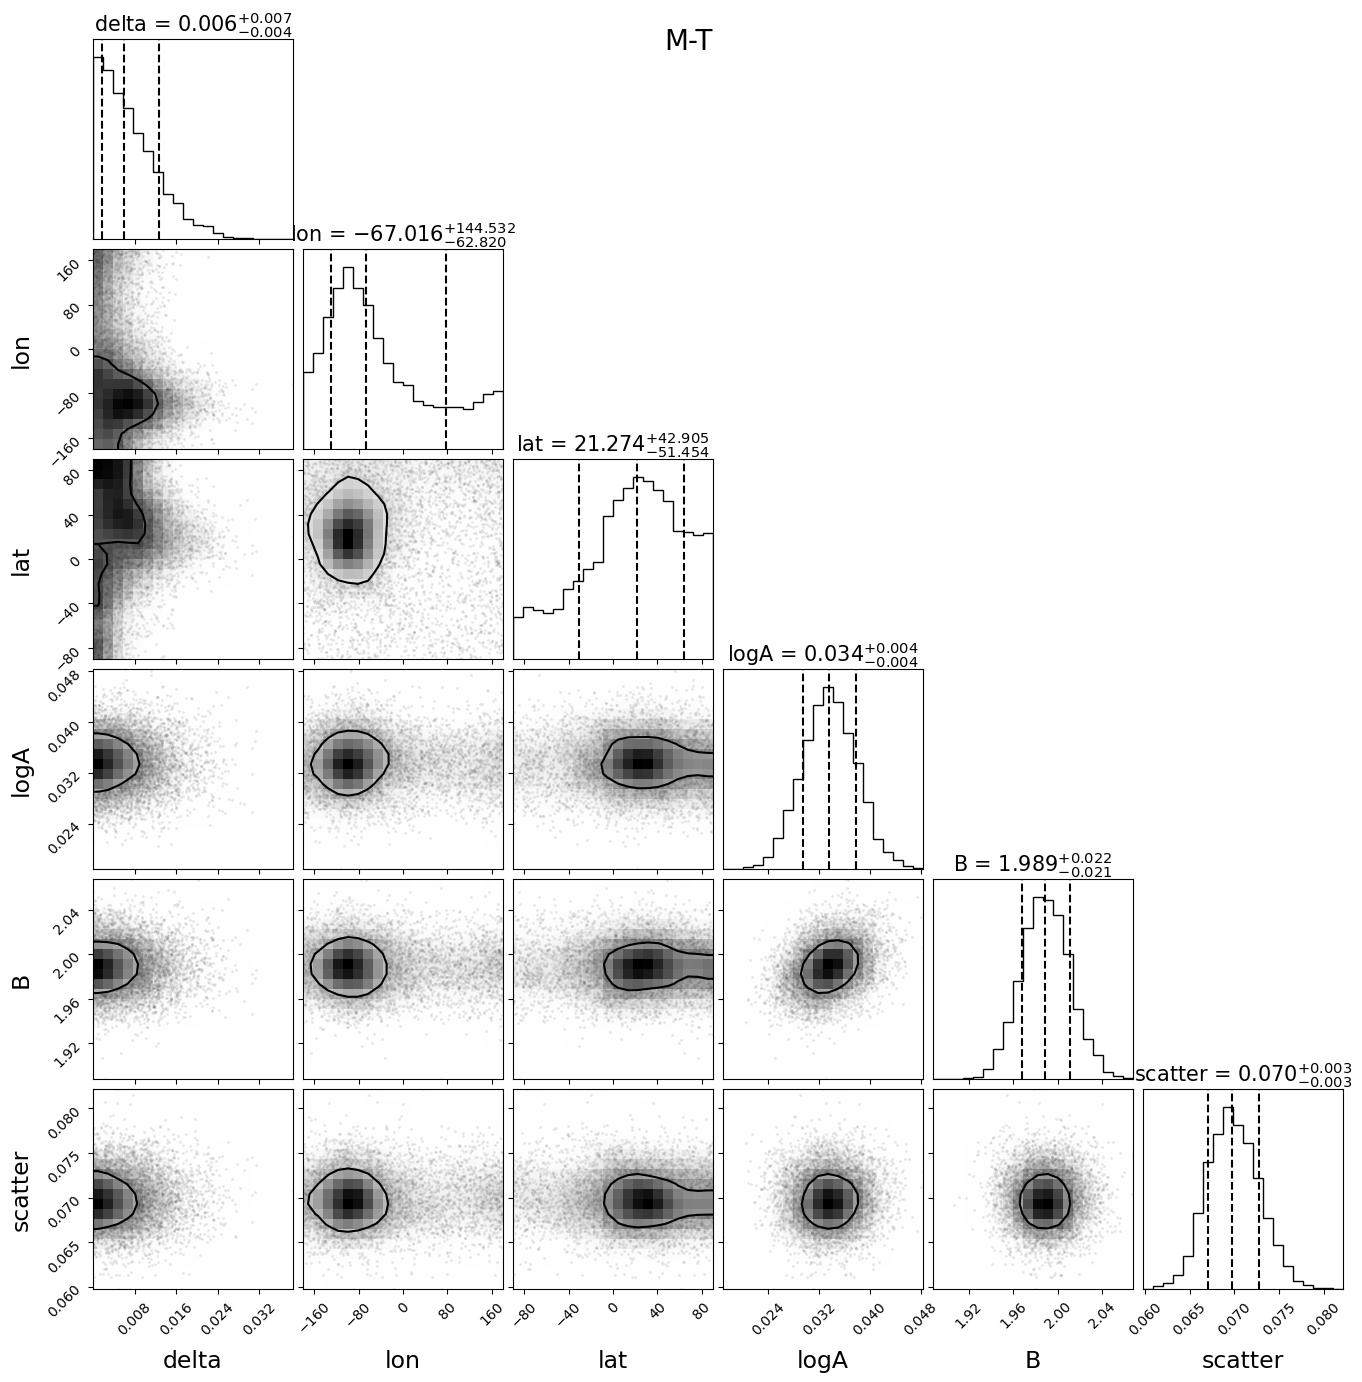

In [86]:
import corner
import matplotlib.pyplot as plt

fig = corner.corner(
    flat_samples, 
    labels=['delta', 'lon', 'lat', 'logA', 'B', 'scatter'], 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, 
    title_fmt='.3f',
    title_kwargs={"fontsize": 15},
    label_kwargs={"fontsize": 17},
    smooth=1,
    levels=[0.39],
)

# Title
fig.suptitle(f'{yname}-{xname}', fontsize=20)

## Interpretation of the results

In [87]:
# The highest probability values and the quantiles for vlon 
vlon_distr = flat_samples[:, 1].copy()
hist, edges = np.histogram(vlon_distr, bins=30, density=True)
peak_vlon = edges[np.argmax(hist)]

# Shift to peak=0 to avoid breaking near the edge
vlon_distr = (vlon_distr - peak_vlon - 180) % 360 - 180 # Despite the shift, keep the range in 180 to 180

# 34th percentile around the peak value
peak_percentile = np.sum(vlon_distr < 0) / len(vlon_distr) * 100
l = np.percentile(vlon_distr, peak_percentile - 34)
u = np.percentile(vlon_distr, peak_percentile + 34)

# Convert back to the original coordinates
lower_vlon = (l + peak_vlon + 180) % 360 - 180
upper_vlon = (u + peak_vlon + 180) % 360 - 180
print(f'vlon: {lower_vlon} ~ {upper_vlon} \nor {peak_vlon} +{u-0} -{0-l}')

vlon: -178.27335301224178 ~ -14.994604901265518 
or -95.99436355340427 +80.99975865213875 -82.27898945883751


In [88]:
# Most probable direction in 3d distribution
hist3d, edges = np.histogramdd(flat_samples[:,:3], bins=30, range=None, density=None, weights=None)
peak_ubf, peak_vlon, peak_vlat = np.where(hist3d==hist3d.max())
peak_ubf = edges[0][peak_ubf][0]
peak_vlon = edges[1][peak_vlon][0]
peak_vlat = edges[2][peak_vlat][0]
print(peak_ubf, peak_vlon, peak_vlat)

0.011534667411398648 -95.99436355340427 5.9943124807959265


Text(0.5, 0.98, 'M-T')

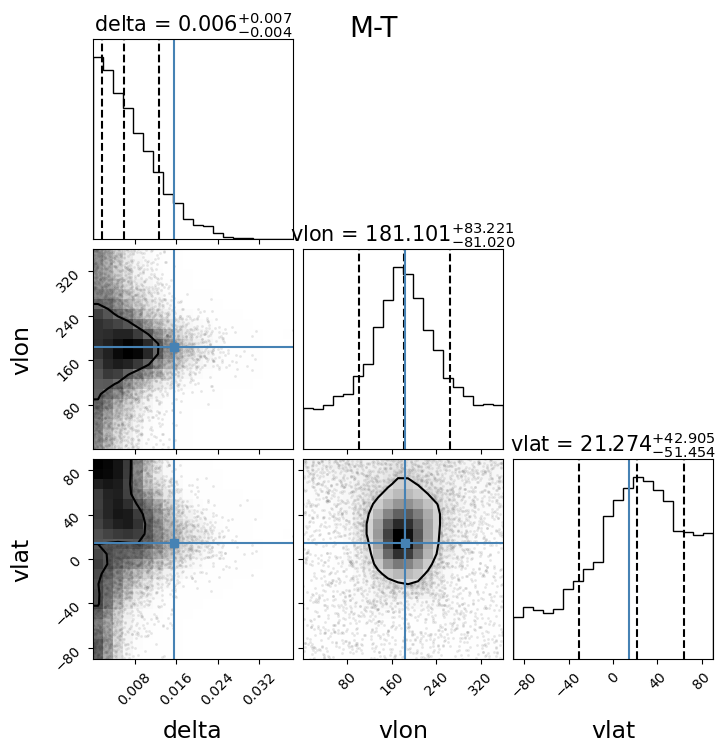

In [91]:
import corner
import matplotlib.pyplot as plt

plot_samples = flat_samples.copy()
plot_samples[:, 1] = (plot_samples[:, 1] - peak_vlon + 180) % 360

fig = corner.corner(
    plot_samples[:, :3],
    labels=['delta', 'vlon', 'vlat'],
    quantiles=[0.16, 0.5, 0.84],
    #truths=[0.098, -64, 22], # YSZ-T [0.049, -64 - peak_vlon + 180, 22] if you want to shift it
    #truths=[0.048, -64-peak_vlon+180, 32], # LX-T
    truths=[0.031, -92-peak_vlon+180, 14], # Mgas-T
    levels=[0.39],
    show_titles=True, 
    title_fmt='.3f',
    title_kwargs={"fontsize": 15},
    label_kwargs={"fontsize": 17},
    smooth=1
)

# Extract the axes
fig.suptitle(f'{yname}-{xname}', fontsize=20)